# Introduction

This notebook illustrates a parametrized classifier trained on a Gaussian example with a two-dimensional (spherical) family of parameters.

It will cover how to:

- train a classifier to distinguish between samples drawn from the "background" Gaussian distribution, $\mathcal{N}\left(\left[\begin{matrix}0 \\ 0 \end{matrix}\right], \left[\begin{matrix}1 & 0\\0 & 1 \end{matrix}\right]\right)$ and the "signal" Gaussian distribution, $\mathcal{N}\left(\left[\begin{matrix}\mu(\theta,\phi) \\ 0 \end{matrix}\right], \left[\begin{matrix}\nu_1(\theta,\phi) & 0\\0 & \nu_2(\theta,\phi) \end{matrix}\right]\right) = \mathcal{N}\left(\left[\begin{matrix} \frac{1-\cos\phi}{2} \\ 0 \end{matrix}\right], \left[\begin{matrix} \frac{2-\cos\theta\sin\phi}{2} & 0\\0 & \frac{2-\sin\theta\sin\phi}{2} \end{matrix}\right]\right)$ 

- use a parametried classifier to infer what pair ($\theta, \phi$) a sample was created with. 

## Imports

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('..', '..')))

In [2]:
import numpy as np
import datetime
import sklearn.metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.stats import chi
from scipy import stats
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
import utils
from utils.functions import mean_gen, varx_gen, vary_gen, spherical_data, test_on_integers, discrete_angles
from utils.functions import learn_parameters, likelihood_ratio, compare_learning, compare_learning_thorough
from tensorflow.python.framework.ops import disable_eager_execution
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# Building the interpolated model through sampling the parameter sphere

## Generating Data

In [3]:
n = 200000

n_th = 50 # number of discrete random thetas to sample in range (0, 2 * pi)
n_ph = 50 # number of discrete random phis to sample in range (0, pi)
thetas = discrete_angles(n, n_th, 2)
phis = discrete_angles(n, n_ph, 1)
name = ('discrete_model_mth%.0f_mph%.0f' %(n_th, n_ph))

x_train, x_test, y_train, y_test = spherical_data(n, thetas, phis)

## Training Interpolated Model

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
]);

loss_fn = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

batch_size = 5000

checkpoint_path = "checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
    save_freq=10*batch_size
)

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

EPOCHS=30
model.fit(
    x_train, y_train, epochs=EPOCHS,
    batch_size=batch_size,
    callbacks=[cp_callback, tensorboard_callback]
);

model.save('3dmodels/' + name)

Epoch 1/30


2022-10-12 14:03:13.025578: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


64/64 [==============================] - 1s 7ms/step - loss: 0.6608 - accuracy: 0.5933
Epoch 2/30
64/64 [==============================] - 0s 6ms/step - loss: 0.6480 - accuracy: 0.6098
Epoch 3/30
64/64 [==============================] - 0s 7ms/step - loss: 0.6456 - accuracy: 0.6122
Epoch 4/30
64/64 [==============================] - 0s 6ms/step - loss: 0.6442 - accuracy: 0.6137
Epoch 5/30
64/64 [==============================] - 0s 6ms/step - loss: 0.6431 - accuracy: 0.6150
Epoch 6/30
64/64 [==============================] - 0s 6ms/step - loss: 0.6423 - accuracy: 0.6153
Epoch 7/30
64/64 [==============================] - 0s 6ms/step - loss: 0.6415 - accuracy: 0.6164
Epoch 8/30
64/64 [==============================] - 0s 6ms/step - loss: 0.6410 - accuracy: 0.6171
Epoch 9/30
64/64 [==============================] - 0s 6ms/step - loss: 0.6404 - accuracy: 0.6176
Epoch 10/30
64/64 [==============================] - 0s 6ms/step - loss: 0.6402 - accuracy: 0.6174
Epoch 11/30
64/64 [===========

# Learning a single point $(\theta, \phi)$ on the parameter sphere from data

## Generating Data

In [5]:
# Generate Data from a single point on the parameter sphere
seed = 44444
n = 10000
theta = 2.45
phi = 1.21
thetas, phis = theta * np.ones(n), phi * np.ones(n)
x_train, x_test, y_train, y_test = spherical_data(n, thetas, phis, seed)
x_inputs = x_train[:, 0:2]

# Likelihood Ratio of Data
l_out = likelihood_ratio(x_train)

## Build Likelihood Model Parameter-Finder (for benchmark)

In [6]:
# Kernel Initializer
s = tf.convert_to_tensor([1.]).shape
res = tf.random.uniform(s, maxval=2*np.pi, seed=seed), tf.random.uniform(s, maxval=np.pi, seed=seed)
def my_init(shape, dtype=None):
    return tf.transpose(tf.convert_to_tensor(res))

# Likelihood Model

loss_fn0 = tf.keras.losses.BinaryCrossentropy()

# Building model_angles which is used to train (theta, phi)
inputs_hold0 = tf.keras.Input(shape=(1,))
simple_linear0 = Dense(2, use_bias = False, kernel_initializer=my_init)(inputs_hold0)
model_angles0 = Model(inputs = inputs_hold0, outputs = simple_linear0)

# Building model_parmafinder, inputs, which takes the (x, y) and finds the best (theta, phi)
raw_inputs0 = tf.keras.Input(shape=(2,))
inputs0 = tf.keras.layers.concatenate([raw_inputs0, model_angles0(tf.ones_like(raw_inputs0)[:,0:1])])
output0 = likelihood_ratio(inputs0)

model_likelihood_paramfinder = Model(inputs = raw_inputs0, outputs = output0)
model_likelihood_paramfinder.compile(loss=loss_fn0, optimizer='Adam')

## Build Interpolated Model Parameter-Finder

In [7]:
# Loading Previously Trained Interpolated Model 
model_interpolate = tf.keras.models.load_model('3dmodels/discrete_model_mth50_mph50')
for l in model_interpolate.layers:
    l.trainable=False
    
loss_fn = tf.keras.losses.BinaryCrossentropy()

# Building model_angles which is used to train (theta, phi)
inputs_hold = tf.keras.Input(shape=(1,))
simple_linear = Dense(2, use_bias = False, kernel_initializer=my_init)(inputs_hold)
model_angles = Model(inputs = inputs_hold, outputs = simple_linear)

# Building model_parmafinder, inputs, which takes the (x, y) and finds the best (theta, phi)
raw_inputs = tf.keras.Input(shape=(2,))
inputs = tf.keras.layers.concatenate([raw_inputs, model_angles(tf.ones_like(raw_inputs)[:,0:1])])
output = model_interpolate(inputs)

model_interpolate_paramfinder = Model(inputs = raw_inputs, outputs = output)
model_interpolate_paramfinder.compile(loss=loss_fn, optimizer='Adam')

## Train and Compare Models

Initialized at  tf.Tensor([1.2422765 2.10618  ], shape=(2,), dtype=float32) tf.Tensor([1.2422765 2.10618  ], shape=(2,), dtype=float32)
54/54 [==============================] - 0s 1ms/step - loss: 0.7265
0 Fitted result 1:  tf.Tensor([1.29396   2.0558114], shape=(2,), dtype=float32)
0 Fitted result 2:  tf.Tensor([1.2942629 2.0533679], shape=(2,), dtype=float32)
54/54 [==============================] - 0s 1ms/step - loss: 0.7195
1 Fitted result 1:  tf.Tensor([1.3421074 2.0075798], shape=(2,), dtype=float32)
1 Fitted result 2:  tf.Tensor([1.3437978 2.0028067], shape=(2,), dtype=float32)
54/54 [==============================] - 0s 1ms/step - loss: 0.7119
2 Fitted result 1:  tf.Tensor([1.3883721 1.9598764], shape=(2,), dtype=float32)
2 Fitted result 2:  tf.Tensor([1.3918152 1.9543165], shape=(2,), dtype=float32)
54/54 [==============================] - 0s 1ms/step - loss: 0.7064
3 Fitted result 1:  tf.Tensor([1.4318476 1.9144993], shape=(2,), dtype=float32)
3 Fitted result 2:  tf.Tensor([1

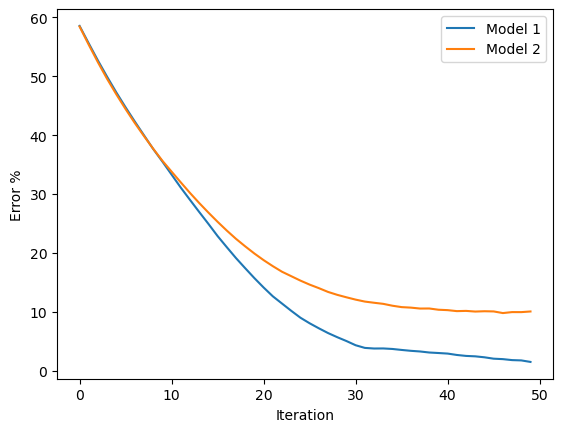

In [8]:
epochs, iterations, batch_size = 1, 50, 300

# Comparing
angles = np.array([theta, phi])
list_mlp, list_mip = compare_learning(model_likelihood_paramfinder, model_interpolate_paramfinder, angles,
                                      x_train, y_train, iterations, epochs, batch_size)

## Validation

In [163]:
tx, ty, tz = varx_gen(theta, phi), vary_gen(theta, phi), mean_gen(theta, phi)
lx, ly, lz = varx_gen(list_mlp[-1][0], list_mlp[-1][1]), vary_gen(list_mlp[-1][0], list_mlp[-1][1]), mean_gen(list_mlp[-1][0], list_mlp[-1][1])
ix, iy, iz = varx_gen(list_mip[-1][0], list_mip[-1][1]), vary_gen(list_mip[-1][0], list_mip[-1][1]), mean_gen(list_mip[-1][0], list_mip[-1][1])

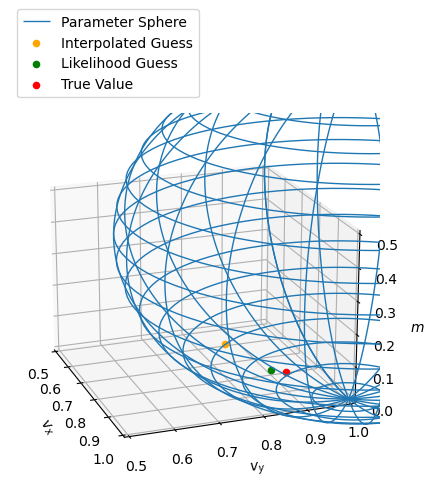

In [162]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x = 1 - 0.5 * np.outer(np.cos(u), np.sin(v))
y = 1 - 0.5 * np.outer(np.sin(u), np.sin(v))
z = 0.5 - 0.5 * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_wireframe(x, y, z, cmap='PuBu', linewidth=1, rstride=5, cstride=5)
ax.scatter(ix, iy, iz, color='orange', linewidth=1)
ax.scatter(lx, ly, lz, color='green', linewidth=1)
ax.scatter(tx, ty, tz, color='red', linewidth=1)
ax.set_xlabel('$v_x$')
ax.set_ylabel('$v_y$')
ax.set_zlabel('$m$')
x_window, y_window, z_window = 1, 1, .5
ax.set_xlim3d(.5, x_window)
ax.set_ylim3d(.5, y_window)
ax.set_zlim3d(0, z_window)
ax.view_init(elev=20., azim=-20)
ax.legend(['Parameter Sphere', 'Interpolated Guess', 'Likelihood Guess', 'True Value'], loc='upper left', 
          bbox_to_anchor=(0, 0, 1, 1.3))